# Starman

This notebook integrates the orbit of Elon Musk's Tesla and Starman. The orbital parameters are taken from Bill Gray's website: https://www.projectpluto.com/temp/j95.htm#elements.

In [1]:
import rebound
import numpy as np

We start by querying NASA Horizons for the Solar System planets around the time of the orbit injection. 

In [2]:
sim = rebound.Simulation()
sim.add(["Sun","Mercury","Venus","Earth","Mars","Jupiter","Saturn","Uranus","Neptune"],date="2018-02-10 00:00")
sim.save("ss.bin")

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Mercury'... Found: Mercury Barycenter (199).
Searching NASA Horizons for 'Venus'... Found: Venus Barycenter (299).
Searching NASA Horizons for 'Earth'... Found: Earth-Moon Barycenter (3).
Searching NASA Horizons for 'Mars'... Found: Mars Barycenter (4).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).
Searching NASA Horizons for 'Uranus'... Found: Uranus Barycenter (7).
Searching NASA Horizons for 'Neptune'... Found: Neptune Barycenter (8).


We stored the simulation to a binary file. This allows us to reload it quickly to play around with things without having to query NASA Horizons too often.

Next up, we add the tesla to the simulation.

In [3]:
sim = rebound.Simulation.from_file("ss.bin")
sim.add(primary=sim.particles[0],
        M=3.68007 *np.pi/180.,
        a=1.34126487,
        omega = 177.28664 *np.pi/180.,
        Omega = 317.45885 *np.pi/180.,
        e = 0.2648281,
        inc = 1.09424 *np.pi/180.)

Let's calculate the characteristic energy (should be about $12~{\rm km}^2/{\rm s}^2$).

In [4]:
tesla = sim.particles[-1]
earth = sim.particles[3]
r=np.linalg.norm(np.array(tesla.xyz) - np.array(earth.xyz))
v=np.linalg.norm(np.array(tesla.vxyz) - np.array(earth.vxyz))
energy = 0.5*v*v-earth.m/r
c3 = 2.*energy*887.40652 # from units where G=1, length=1AU to km and s
print("c3 = %f (km^2/s^2)" % c3)

c3 = 11.943788 (km^2/s^2)


That seems about right! So let's look at the orbit. It starts at Earth's orbit, crosses that of Mars and then enters the asteroid belt.

/Users/rein/git/rebound/venv/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


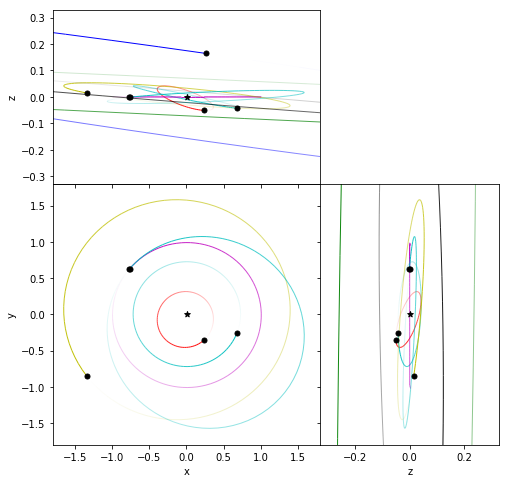

In [6]:
rebound.OrbitPlot(sim,lim=1.8,slices=True,color=True);

And then integrate it forward in time. Here, we use the hybrid integrator MERCURIUS. You can experiment with other integrators which might be faster, but since this is an eccentric orbit, you might see many close encounters, so you either need a non-symplectic integrator such as IAS15 or a hybrid integrator such as MERCURIUS.

In [7]:
# integrate
sim.dt = sim.particles[1].P/60. # small fraction of Mercury's period
sim.integrator="mercurius"  
N = 1000
times = np.linspace(0.,2.*np.pi*1e5,N)
a = np.zeros(N)
e = np.zeros(N)
for i,t in enumerate(times):
    sim.integrate(t,exact_finish_time=0)
    orbit = sim.particles[-1].calculate_orbit(primary=sim.particles[0])
    a[i] = orbit.a
    e[i] = orbit.e

Let's plot the orbital parameters!

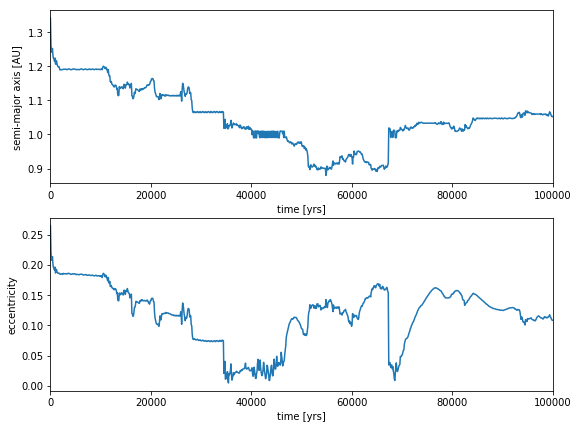

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,7))
ax = plt.subplot(211)
ax.set_xlim([0,np.max(times)/2./np.pi])
ax.set_xlabel("time [yrs]")
ax.set_ylabel("semi-major axis [AU]")
plt.plot(times/2./np.pi,a)
ax = plt.subplot(212)
ax.set_xlim([0,np.max(times)/2./np.pi])
ax.set_xlabel("time [yrs]")
ax.set_ylabel("eccentricity")
plt.plot(times/2./np.pi,e);

To check the sensitivity of the integrations, let us perturb the initial orbit by a small factor equal to the confidence interval posted by Bill Gray. Instead of just integrating one particle at a time, we here add 10 test particles. We also switch to the high precision IAS15 integrator to get the most reliable result.

In [9]:
sim = rebound.Simulation.from_file("ss.bin")
Ntesla = 10
for i in range(Ntesla):
    sim.add(primary=sim.particles[0],
        M=(3.68007+0.0013*np.random.normal()) *np.pi/180.,
        a=(1.34126487+0.000273*np.random.normal()),
        omega = (177.28664+0.00059*np.random.normal()) *np.pi/180.,
        Omega = (317.45885+0.0007*np.random.normal()) *np.pi/180.,
        e = (0.2648281+0.00015*np.random.normal()),
        inc = (1.09424+0.0007*np.random.normal()) *np.pi/180.)
sim.N_active = 9 # Sun + planets

Let's integrate this...

In [10]:
sim.dt = sim.particles[1].P/60. # small fraction of Mercury's period
sim.integrator="ias15"  
N = 1000
times = np.linspace(0.,2.*np.pi*1e3,N)
a_log = np.zeros((N,Ntesla))
e_log = np.zeros((N,Ntesla))
for i,t in enumerate(times):
    sim.integrate(t,exact_finish_time=0)
    for j in range(Ntesla):
        orbit = sim.particles[9+j].calculate_orbit(primary=sim.particles[0])
        a_log[i][j] = orbit.a
        e_log[i][j] = orbit.e

When plotting the semi-major axis and eccentricity of all orbits, note that their kicks are correlated. This is because they are all due to close encounters with the Earth. This fast divergence means that we cannot predict the trajectory for more than a hundred years without knowing the precise initial conditions and all the non-gravitational effects that might be acting on a car in space.

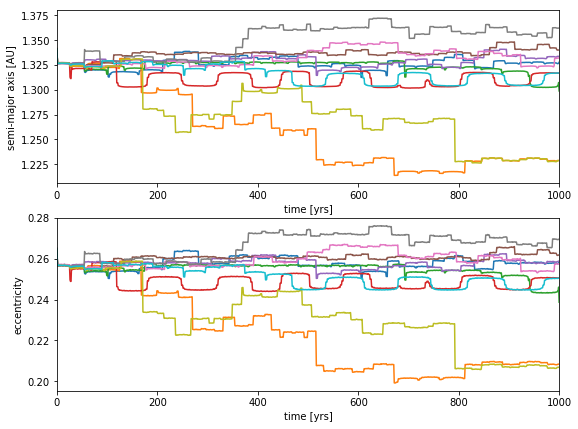

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,7))
ax = plt.subplot(211)
ax.set_xlim([0,np.max(times)/2./np.pi])
ax.set_xlabel("time [yrs]")
ax.set_ylabel("semi-major axis [AU]")
for j in range(Ntesla):
    plt.plot(times/2./np.pi,a_log[:,j])
ax = plt.subplot(212)
ax.set_xlim([0,np.max(times)/2./np.pi])
ax.set_xlabel("time [yrs]")
ax.set_ylabel("eccentricity")
for j in range(Ntesla):
    plt.plot(times/2./np.pi,e_log[:,j])